## 1. Initialization

### 1.1 Download packages
You might need to add other packages imported in 1.2 if you run the notebook on your local machine.

In [1]:
!pip install pydub

### 1.2 Import librairies

In [2]:
from IPython.lib.display import Audio
from pydub import AudioSegment
from pydub.playback import play
import librosa 
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
import glob
import warnings
import tempfile
import soundfile as sf
import collections
import os
warnings.filterwarnings('ignore')
import scipy
from numba import jit


C:\ProgramData\Anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


### 1.3 Mount Google Drive folder 
(add this folder to your Drive): https://drive.google.com/drive/folders/16cU8d0q9idGgqT3BYhk7CtRS3SskSmkZ?usp=sharing

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google'

### 1.4 Load Harmonix dataset metadata
modify root_path so that it points to the "TP Shazam" folder if necessary

In [ ]:
root_path = "/content/drive/My Drive/TP Shazam/"

df_ref_small = pd.read_csv(root_path +"metadata/REFSmallSet.csv") # test set of small extracts
df_test_small = pd.read_csv(root_path +"metadata/TESTSmallSet.csv") # test set of small extracts
df_ref_large = pd.read_csv(root_path + "metadata/REFLargeSet.csv") # large reference set used to build the fingerprint index
df_test_large = pd.read_csv(root_path +"metadata/TESTLargeSet.csv") # reference set of small extracts
df_enigma = pd.read_csv(root_path + "metadata/TESTEnigmaSet.csv") # test set of unkown songs
df_background = pd.read_csv(root_path + "metadata/background.csv")
df_harmonix = pd.read_csv(root_path + "metadata/harmonix.csv") # whole harmonix dataset (not used here)


list_dfs = [df_ref_small, df_test_small, df_ref_large, df_test_large, df_enigma, df_background, df_harmonix]

for df in list_dfs:
    df["Filepath"] = df["Filepath"].apply(lambda path: root_path + path)
    if "Spectrogram" in df.columns:
        df["Spectrogram"] = df["Spectrogram"].apply(lambda path: root_path + path)
    if "Fingerprint" in df.columns:
        df["Fingerprint"] = df["Fingerprint"].apply(lambda path: root_path + path)

### 1.5 Utilities

In [ ]:
def load_audio(filepath, sr=22050, mono=True, dtype='float32'):
    # load mp3
    mp3 = AudioSegment.from_mp3(filepath)
    
    # convert to wav and temporarily save it to file
    _, path = tempfile.mkstemp()
    mp3.export(path, format="wav")

    # load wav file
    x, fs = sf.read(path)
    
    # clean up
    os.remove(path)

    # reduce to mono channel
    if mono and len(x.shape)>1:
        x = np.mean(x, axis = 1)

    # resample and change data type
    x = scipy.signal.resample_poly(x, sr, fs)
    x = x.astype(dtype)

    return x

def load_spectrogram(filepath):
    return np.load(filepath)

def compute_spectrogram(audio, n_fft=2048, hop_length=1024, n_bins=100):
    # build spectrogram
    spectrogram = np.abs(librosa.stft(audio, n_fft, hop_length, win_length=n_fft, window="hanning"))
    
    # normalize 
    spectrogram = spectrogram/np.max(spectrogram)
    
    # return first n bins
    return spectrogram[:n_bins, :]

def play_audio(audio, sr=22050):
    display(Audio(audio, rate=sr))

def sec_to_frame(sec, sr=22050, hop_length=1024):
  return int(sec * sr/hop_length)

def frame_to_sec(frame, sr=22050, hop_length=1024):
    return frame * hop_length/sr

def sec_to_sample(sec, sr=22050):
  return int(sec*sr)

def sample_to_sec(sample, sr=22050):
  return sample/sr

def plot_spectrogram(spectrogram):
    _, ax = plt.subplots(1, 1, figsize=(7,3), dpi=100)

    ax.imshow(np.log(1+100*spectrogram), origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    
    ax.set_xlabel('Time (frames)')
    ax.set_ylabel('Frequency (bins)')
    ax.set_title('Spectrogram')


def time_stretch(y, rate, sr=22050):
    rate = np.random.uniform(0.8, 1.2)
    y_stretch = librosa.effects.time_stretch(y, rate=rate)
    return y_stretch

def pitch_shift(y, n_semitones, sr=22050):
  y_shift = librosa.effects.pitch_shift(y, sr, n_semitones)
  return y_shift

def add_noise(y, snr_db):
    snr_lin = 10**(snr_db/20)
    rms = np.mean(np.square(y))
    noise = np.random.randn(len(y)) * np.sqrt(rms/snr_lin)
    y_noisy = y + noise
    return y_noisy

def add_background(y, snr_db, sr=22050):
    snr_lin = 10**(snr_db/20)
    id_back = np.random.randint(0,10)
    path_background = df_background["Filepath"][id_back]
    background = load_audio(path_background, sr)
    len_audio = min(len(y), len(background))
    background = background[:len_audio]
    y = y[:len_audio]
    rms_y = np.mean(np.square(y))
    rms_back = np.mean(np.square(background))
    background = background * np.sqrt(rms_y/(snr_lin*rms_back))
    y_back = y + background
    return y_back
      
def crop_audio(y, sr, start, end):
  return y[int(sr*start):int(sr*end)]

### 1.6 Explore database

In [4]:
# load audio and compute spectrogram
audio = load_audio(df_ref_small["Filepath"][0])
spectrogram = compute_spectrogram(audio)

# alternatively, load precomputed spectrogram
spectrogram_precomputed = df_ref_small["Spectrogram"][0]

# plot
plot_spectrogram(spectrogram[:, sec_to_frame(5):sec_to_frame(15)])

NameError: name 'load_audio' is not defined

In [5]:
# play audio
play_audio(audio[sec_to_sample(5):sec_to_sample(15)])

NameError: name 'play_audio' is not defined

## 2. Shazam algorithm

### 2.1 Fingerprint computation

In [ ]:

def compute_fingerprint(spectrogram, frequency_step=6, time_step=14):
    """ Compute fingerprint of a song from its spectrogram
        Args:
            spectrogram: the spectrogram from which we compute the fingerprint
            frequency_step: height of a cell of the grid
            time_step: width of a cell of the grid
        Returns:
            fingerprint: a numpy array of the shape [(f_1, t_1), ..., (f_n, t_n)]
    """
  # TODO: compute fingerprint
  return fingerprint


def plot_fingerprint(fingerprint, spectrogram, frame_range=[200, 400], frequency_step=6, time_step=14):
    """ Plot fingerprint on the spectrogram
        Args:
            fingerprint: the shazam fingerprint
            spectrogram: the input spectrogram
            frame_range: x range of the plot
            frequency_step: height of a cell of the grid
            time_step: width of a cell of the grid
    """
  # TODO: plot the spectrogram, the grid and the 
  pass


def compute_index(fingerprint, zone_dimension=[30, 40], dist_blc=[5, -20]):
    """ Build keys associated with the song
        Args:
            fingerprint: the shazam fingerprint
            zone_dimension: dimension of the target zone (time_width, frequency_width)
            dist_blc: relative position of the bottom left corner of the target zone (time offset, frequency offset)
        Returns:
            index: a dictionary of triplets of the form (f_1, f_2, t_2 - t_1) -> t1
                   where,
                   (f1, t1) is a cell maximum
                   (f2, t2) is a cell maximum within the target zone
    """
    # TODO: return 
    # Tips : the structure collections.defaultdict(list) comes in handy
    return index

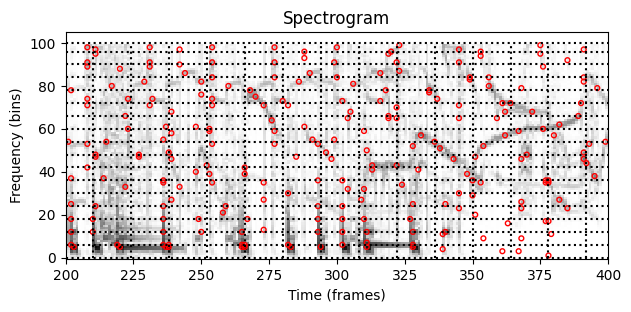

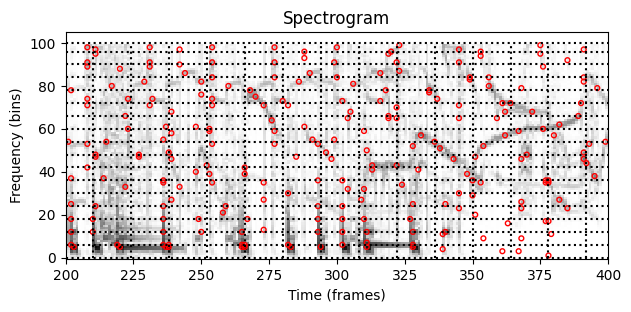

In [ ]:
# compute fingerprint
spectrogram = np.load(df_ref_small["Spectrogram"][0])
fingerprint = compute_fingerprint(spectrogram)

# plot fingerprint and spectrogram
plot_fingerprint(fingerprint, spectrogram)

# compare with precomputed fingerprint
fingerprint_precomputed = np.load(df_ref_small["Fingerprint"][0])
plot_fingerprint(fingerprint_precomputed, spectrogram)

# compute song indexes
index = compute_index(fingerprint)

### 2.2 Search and histogram computation

In [ ]:
def index_matching(index_query, index_ref):
    """ Compare two indexes and find best shift
        Args:
            index_query: triplet dictionary of the query
            index_ref: triplet dictionary of the reference
        Returns:
            best_match_score: number of matching keys
            best_match_offset: time shift maximizing the  match
    """
    shift_match = collections.defaultdict(int)
    for k in index_query.keys():
        for t_ref in index_ref[k]:
            for t_query in index_query[k]:
                shift_match[t_ref-t_query] += 1
    best_match_score = max(shift_match.values())
    best_match_offset = max(shift_match, key=shift_match.get)

    return best_match_score, best_match_offset, shift_match

def plot_histogram(shift_match):
    """ Compare two indexes and find best shift
        Args:
            shift_max : 
    """
    # TODO : plot histogram
    pass

In [ ]:
# load fingerprint
fingerprint_ref = np.load(df_ref_small["Fingerprint"][0])
audio_query = load_audio(df_test_small["Filepath"][0])
fingerprint_query = compute_fingerprint(compute_spectrogram(audio_query))

# load index
index_ref = compute_index(fingerprint_ref)
index_query = compute_index(fingerprint_query)

# compare index
best_match_score, best_match_offset, shift_max = index_matching(index_query, index_ref)
print(f"Best match score : {best_match_score}")
print(f"Best match offset : {round(frame_to_sec(best_match_offset), 2)}s")

# plot spectrogram
plot_histogram(shift_max)

In [ ]:
def compute_global_index(df):
    """ Build global index from a database
        Args:
            df : the song database
        Returns:
            index : a dictionary of triplets of the form (f_1, f_2, t_2 - t_1) -> (t1, song_index) built from all songs in the database
                   where,
                   (f1, t1) is a cell maximum
                   (f2, t2) is a cell maximum within the target zone
                   song_index is the index of the song in the database
    """
    # TODO : build global index
    return index

def index_matching_global(index_query, index_ref):
    """ Find best match in global index
        Args:
            index_query: triplet dictionary of the query
            index_ref: global index
        Returns:
            best_match_song_id
            best_match_score: number of matching keys
            best_match_offset: time shift maximizing the match
            shift_match : histogram of matches
    """
    # TODO : find best match
    
    return best_match_song_id, best_match_score, best_match_offset, shift_match

In [ ]:
# compute global index of REFSmallSet
index_small = compute_global_index(df_ref_small)

# save to file
with open(f"{root_path}index_small.pickle", 'wb') as handle:
    pickle.dump(indexing, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#Load dictionnary when it's stored
with open(f"{root_path}index_small.pickle", 'wb') as handle:
    index_small = pickle.load(handle)

In [ ]:
# load query
id_query = 0
audio_query = load_audio(df_test_small["Filepath"][id_query])
fingerprint_query = compute_fingerprint(compute_spectrogram(audio_query))

# shazam
print(f"Comparing input to the database (10 songs) ...")
start = time.time()
best_match_song_id, best_match_score, best_match_offset, shift_match = index_matching_global(index_query, index_ref)
end = time.time()
print(f"Runtime of {round(end-start, 3)}s")

# print results
print(f"Best match score : {best_match_score}")
print(f"Best match offset : {round(best_match_offset * hop_length/sr,2)}s")
print(f"Best match name : {df_test_small.iloc[best_match_song_id]['Title']}")
print(f"Query name : {df_test_small.iloc[id_query]['Title']}")

## 3. Experiments

### 3.1 Experiment 1
Evaluate your algorithm by measuring the recognition rate on a small dataset. this will be done by
running the recognition for each test audio excerpt of the test set ”TESTSmallSet” which is composed
of 10 excerpt of 5s from the 10 music recordings of the reference test (REFSmallSet)





### 3.2 Experiment 2
Evaluate your algorithm by measuring the recognition rate on a larger dataset. This is the same
experiment as Experience 1 by replacing the test set by ”TESTLargeSet” and the reference set by
(REFLargeSet)

### 3.3 Experiment 3
The goal of this experiment is to evaluate your algorithm by measuring its robustness to potential
modifications or effects (noise addition and speed changes, in particular)
1. Use the provided functions to generate new test sets from the ”TESTSmallSet” with varying level
of additional noise (white noise or recorded background noise from −10db to +10db), varying
level of speed modifications (from ±1% to ±10%) and varying pitch shifting, and measure the
recognition rates as a function of the strength of the modification
2. Propose and implement potential solutions to limit this robustness problem.

In [ ]:
# load audio and compute spectrogram
audio = load_audio(df_ref_small["Filepath"][0])

# Apply transformations
snr_db = -10
stretch_rate = 1.1
semitones_shift = -2

audio_noisy = add_noise(audio, snr_db)
audio_background = add_background(audio,snr_db)
audio_stretched = time_stretch(audio, stretch_rate)
audio_shifted = pitch_shift(audio, semitones_shift)

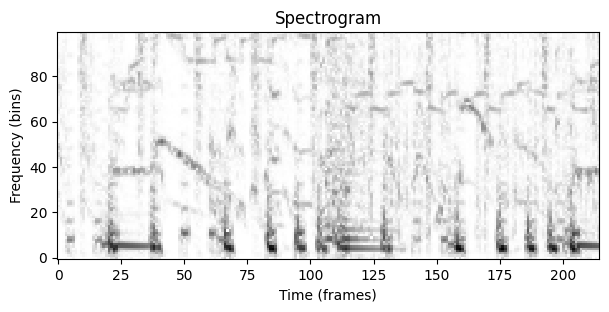

In [ ]:
baudio_to_viz = audio_background

# compute spectrogram
spectrogram = compute_spectrogram(audio_to_viz)
# plot spectrogram
plot_spectrogram(spectrogram)

# Play audio
play_audio(audio_to_viz)

### 3.4 Experiment 4
In the last experiment, we propose to test the algorithm of a provided ”enigma” test set called
”TESTEnigmaSet” which contains 10 unknown audio samples (i.e. samples which have no references
in the reference database).
1. Run your algorithm and observe the result
2. Propose and implement a solution which will permit to identify that these samples are unknown
samples.
3. Evaluate your new algorithm on the TESTSmallSet to check that the recognition rate is not
degraded

### 3.5 Optional
The fingerprint computation is based on computing 1 maximum per cell of a fixed grid. One of the drawback of this implementation is that two maxima can be very close to each other at both sides of a cell limit. An alternative solution is to compute the maxima on a dynamic cell (of similar size) that is slid on all time/frequency point. Evaluate the method with this alternative dynamic grid design for the different experiments run above. What are the drawbacks/advantages of this new method ?

In [ ]:
def compute_fingerprint_v2(spectrogram, freq_size=6, time_size=14):
    """ Compute fingerprint of a song from its spectrogram. For each time-frequency
        point, check if the point is a local maximum within a window of size
        (freq_size, time_size). Store each local maximum in an array.
        
        Args:
            spectrogram: the spectrogram from which we compute the fingerprint
            frequency_step: height the dynamic window
            time_step: width of the dynamic window
        Returns:
            fingerprint: a numpy array of the shape [(f_1, t_1), ..., (f_n, t_n)]
    """
  # TODO: compute fingerprint
  return fingerprint